In [ ]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product

# Práctica 1: Optimización Mono-objetivo (Himmelblau)

En este bloque abordamos la optimización de la **Función de Himmelblau**, un problema multimodal clásico en optimización definido por la siguiente ecuación:

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

El objetivo matemático es encontrar el mínimo global donde $f(x,y)=0$. Esta función presenta 4 mínimos globales idénticos en el rango de búsqueda, lo que añade dificultad para que el algoritmo no se estanque en óptimos locales.

### Estrategia de Diseño
Dado que el dominio de búsqueda es continuo ($x, y \in [-5, 5]$), hemos optado por un **Algoritmo Genético con Codificación Real**.

* **Función de Fitness:** El problema original es de *minimización*. Para adaptarlo al funcionamiento canónico de un GA (que busca *maximizar* aptitud), aplicamos la siguiente transformación:
$$Fitness = \frac{1}{1 + f(x,y)}$$
De esta forma, un coste de $0$ se convierte en un fitness de $1.0$.

In [45]:
LOW, HIGH = -5.0, 5.0
DIM = 2

def himmelblau(ind):
    x, y = ind
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def fitness_himmelblau(ind):
    return 1.0 / (1.0 + himmelblau(ind))


## Inicialización de la población

Cada individuo se representa mediante un vector real de dimensión 2. La población inicial se
genera de forma aleatoria, muestreando uniformemente el dominio de búsqueda.


In [46]:
def create_population(pop_size):
    return [np.random.uniform(LOW, HIGH, size=DIM) for _ in range(pop_size)]


## Evaluación y selección

El algoritmo genético se formula como un problema de **maximización del fitness**. La población se
ordena de acuerdo con este valor y se emplea selección por torneo para introducir presión selectiva
sin perder diversidad.


In [47]:
def sort_pop(pop, fit):
    fits = [fit(ind) for ind in pop]
    pop_fits = sorted(zip(pop, fits), key=lambda x: x[1], reverse=True)
    pop_sorted, fits_sorted = zip(*pop_fits)
    return list(pop_sorted), list(fits_sorted)

def select(pop, T, fit):
    candidates = random.sample(pop, T)
    return copy.deepcopy(max(candidates, key=fit))


## Operadores de cruce

Se han implementado distintos operadores para variables reales, con comportamientos exploratorios
y explotadores complementarios.


In [48]:
def arithmetic_crossover(ind1, ind2, pcross):
    if random.random() > pcross:
        return copy.deepcopy(ind1), copy.deepcopy(ind2)
    alpha = random.random()
    return (
        alpha * ind1 + (1 - alpha) * ind2,
        alpha * ind2 + (1 - alpha) * ind1
    )

def blx_alpha_crossover(ind1, ind2, pcross, alpha=0.5):
    if random.random() > pcross:
        return copy.deepcopy(ind1), copy.deepcopy(ind2)
    c1, c2 = np.zeros(DIM), np.zeros(DIM)
    for i in range(DIM):
        d = abs(ind1[i] - ind2[i])
        low = min(ind1[i], ind2[i]) - alpha * d
        high = max(ind1[i], ind2[i]) + alpha * d
        c1[i] = np.random.uniform(low, high)
        c2[i] = np.random.uniform(low, high)
    return np.clip(c1, LOW, HIGH), np.clip(c2, LOW, HIGH)

def directional_crossover(ind1, ind2, pcross, best, beta=0.5):
    if random.random() > pcross:
        return copy.deepcopy(ind1), copy.deepcopy(ind2)
    return (
        np.clip(ind1 + beta * (best - ind2), LOW, HIGH),
        np.clip(ind2 + beta * (best - ind1), LOW, HIGH)
    )


## Operadores de mutación

Las mutaciones introducen perturbaciones controladas que permiten realizar tanto exploración como
búsqueda local fina en las fases finales del algoritmo.


In [49]:
def gaussian_mutation(ind, pmut, sigma):
    if random.random() > pmut:
        return ind
    return np.clip(ind + np.random.normal(0, sigma, size=DIM), LOW, HIGH)

def cauchy_mutation(ind, pmut):
    if random.random() > pmut:
        return ind
    return np.clip(ind + np.random.standard_cauchy(size=DIM) * 0.1, LOW, HIGH)

def non_uniform_mutation(ind, pmut, b=5):
    if random.random() > pmut:
        return ind
    ind = ind.copy()
    for i in range(DIM):
        if random.random() < 0.5:
            ind[i] += (HIGH - ind[i]) * (1 - random.random() ** b)
        else:
            ind[i] -= (ind[i] - LOW) * (1 - random.random() ** b)
    return np.clip(ind, LOW, HIGH)


## Algoritmo Genético

El algoritmo se ejecuta hasta alcanzar un número máximo de evaluaciones de la función objetivo.
Se emplea elitismo para garantizar que la mejor solución encontrada no se pierde entre generaciones.


In [50]:
def evolve(pop, fit, cfg, max_evals=3500):
    evals = 0
    history = []
    pop_size = len(pop)

    while evals < max_evals:
        pop_sorted, fits_sorted = sort_pop(pop, fit)
        evals += pop_size
        history.append(fits_sorted[0])

        best = pop_sorted[0]
        new_pop = []

        if cfg["elitism"]:
            new_pop.append(copy.deepcopy(best))

        while len(new_pop) < pop_size:
            p1 = select(pop_sorted, cfg["T"], fit)
            p2 = select(pop_sorted, cfg["T"], fit)

            if cfg["dir"]:
                c1, c2 = directional_crossover(p1, p2, cfg["pcross"], best)
            else:
                c1, c2 = cfg["crossover"](p1, p2, cfg["pcross"])

            new_pop.append(cfg["mutation"](c1, cfg["pmut"]))
            if len(new_pop) < pop_size:
                new_pop.append(cfg["mutation"](c2, cfg["pmut"]))

        pop = new_pop

    pop_sorted, fits_sorted = sort_pop(pop, fit)
    return pop_sorted[0], fits_sorted[0], history

## Exploración de configuraciones

Se genera automáticamente el espacio completo de combinaciones de operadores y parámetros
considerados, descartando únicamente aquellas combinaciones que no están bien definidas
(por ejemplo, cruce direccional con operadores no compatibles).


In [51]:

# Operadores

crossovers = {
    "arith": arithmetic_crossover,
    "blx": blx_alpha_crossover
}

mutations = {
    "gauss_01": lambda ind, pmut: gaussian_mutation(ind, pmut, 0.1),
    "gauss_005": lambda ind, pmut: gaussian_mutation(ind, pmut, 0.05),
    "cauchy": cauchy_mutation,
    "non_uniform": non_uniform_mutation
}


# Configuraciones AUTOMÁTICAS

configs = []

for cross, mut, pmut, pcross, T, dir_flag in product(
    crossovers.keys(),
    mutations.keys(),
    [0.05, 0.1],
    [0.7, 0.8, 0.9],
    [2, 4, 6, 8],
    [False, True]
):
    if dir_flag and cross != "arith":
        continue

    configs.append({
        "crossover": crossovers[cross],
        "mutation": mutations[mut],
        "cross_name": cross,
        "mut_name": mut,
        "pmut": pmut,
        "pcross": pcross,
        "T": T,
        "elitism": True,
        "dir": dir_flag
    })

print("Total configuraciones:", len(configs))

Total configuraciones: 288


## Evaluación experimental

Cada configuración se evalúa mediante múltiples ejecuciones independientes para tener en cuenta
el carácter estocástico del algoritmo. Se utilizan estadísticas agregadas para seleccionar la mejor
configuración.


In [52]:

# Experimentos estocásticos

N_RUNS = 10
results = []

def run_experiment(cfg, seed):
    random.seed(seed)
    np.random.seed(seed)
    pop = create_population(50)
    best, best_fit, hist = evolve(pop, fitness_himmelblau, cfg)
    return best_fit, himmelblau(best), hist

for cfg in configs:
    out = Parallel(n_jobs=8)(
        delayed(run_experiment)(cfg, i) for i in range(N_RUNS)
    )

    fitness_vals = [o[0] for o in out]
    cost_vals = [o[1] for o in out]

    results.append({
        "cfg": cfg,
        "fitness_mean": np.mean(fitness_vals),
        "fitness_std": np.std(fitness_vals),
        "fitness_best": np.max(fitness_vals),
        "cost_mean": np.mean(cost_vals),
        "histories": [o[2] for o in out]
    })

    print(cfg["cross_name"], cfg["mut_name"], cfg["dir"],
          "fitness_mean:", np.mean(fitness_vals),
          "fitness_best:", np.max(fitness_vals))

# ============================================================
# Mejor configuración
# ============================================================

best_result = max(results, key=lambda x: x["fitness_mean"])

print("\n========== MEJOR CONFIGURACIÓN ==========")
print("Cruce:", best_result["cfg"]["cross_name"])
print("Mutación:", best_result["cfg"]["mut_name"])
print("Direccional:", best_result["cfg"]["dir"])
print("Fitness medio:", best_result["fitness_mean"])
print("Fitness std:", best_result["fitness_std"])
print("Mejor fitness:", best_result["fitness_best"])
print("Coste medio:", best_result["cost_mean"])

arith gauss_01 False fitness_mean: 0.9996284408784492 fitness_best: 1.0
arith gauss_01 True fitness_mean: 1.0 fitness_best: 1.0
arith gauss_01 False fitness_mean: 0.9991068476363048 fitness_best: 0.9999999997587155
arith gauss_01 True fitness_mean: 0.9994288169146891 fitness_best: 0.9999999998753455
arith gauss_01 False fitness_mean: 0.9986554244730901 fitness_best: 0.9999727826083009
arith gauss_01 True fitness_mean: 0.9984901380818323 fitness_best: 0.9999970034237979
arith gauss_01 False fitness_mean: 0.9990078989617552 fitness_best: 0.9999998268839609
arith gauss_01 True fitness_mean: 0.9993179338264488 fitness_best: 0.9999998478303046
arith gauss_01 False fitness_mean: 0.9994310908906183 fitness_best: 0.9999999999703415
arith gauss_01 True fitness_mean: 0.9999999999999961 fitness_best: 1.0
arith gauss_01 False fitness_mean: 0.9992151003300191 fitness_best: 0.9999999824990872
arith gauss_01 True fitness_mean: 0.9993526553058768 fitness_best: 1.0
arith gauss_01 False fitness_mean: 0.

## Análisis de convergencia

La siguiente figura muestra la evolución del mejor valor de fitness por generación para la mejor
configuración seleccionada.


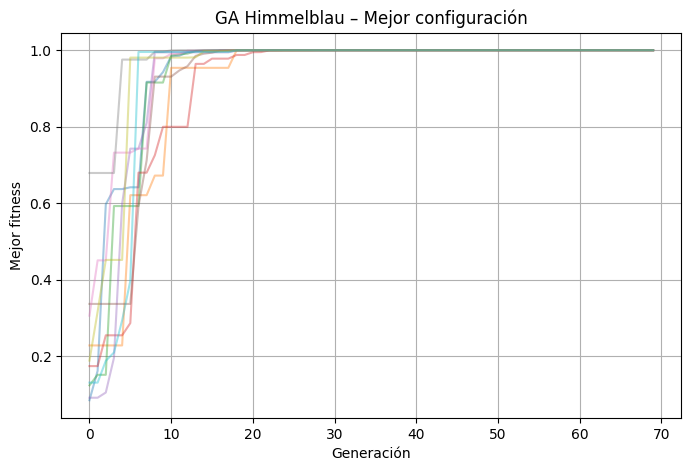

In [53]:
# Gráfica de convergencia

plt.figure(figsize=(8,5))
for hist in best_result["histories"]:
    plt.plot(hist, alpha=0.4)

plt.xlabel("Generación")
plt.ylabel("Mejor fitness")
plt.title("GA Himmelblau – Mejor configuración")
plt.grid(True)
plt.show()


Se muestra la evolución del mejor fitness por generación para 10 ejecuciones independientes
del algoritmo genético utilizando la mejor configuración encontrada. Se observa una convergencia
rápida y consistente hacia el valor máximo de fitness (=1.0), alcanzado en menos de 15 generaciones
en todas las ejecuciones.

Este comportamiento indica que el algoritmo es robusto frente a la estocasticidad inherente al
proceso evolutivo y que las decisiones de diseño adoptadas (codificación real, selección por torneo,
elitismo y operadores explotadores) permiten alcanzar los óptimos globales de la función de
Himmelblau de forma precisa y estable.

La estabilización del fitness en el valor 1.0 corresponde a soluciones con coste del orden de
10⁻¹⁷, lo cual refleja la convergencia hasta el límite de precisión numérica del sistema.


## Selección de la mejor configuración del Algoritmo Genético

Tras evaluar sistemáticamente todas las combinaciones de operadores y parámetros consideradas,
se selecciona la configuración con mayor fitness medio como la mejor configuración del algoritmo
genético para el problema de Himmelblau.


In [54]:
best_cfg = best_result["cfg"]

print("=========== MEJOR CONFIGURACIÓN GA ===========")
print("Cruce:", best_cfg["cross_name"])
print("Mutación:", best_cfg["mut_name"])
print("Cruce direccional:", best_cfg["dir"])
print("pmut:", best_cfg["pmut"])
print("pcross:", best_cfg["pcross"])
print("Torneo (T):", best_cfg["T"])
print("Elitismo:", best_cfg["elitism"])

print("\n=========== RENDIMIENTO ===========")
print("Fitness medio:", best_result["fitness_mean"])
print("Desviación típica fitness:", best_result["fitness_std"])
print("Mejor fitness:", best_result["fitness_best"])
print("Coste medio f(x,y):", best_result["cost_mean"])



=========== MEJOR CONFIGURACIÓN GA ===========
Cruce: arith
Mutación: gauss_01
Cruce direccional: True
pmut: 0.05
pcross: 0.7
Torneo (T): 2
Elitismo: True

=========== RENDIMIENTO ===========
Fitness medio: 1.0
Desviación típica fitness: 0.0
Mejor fitness: 1.0
Coste medio f(x,y): 5.4553948380568024e-17


La mejor configuración funciona bien porque, una vez que el algoritmo se acerca a un óptimo de
Himmelblau, prioriza explotarlo en lugar de seguir explorando. El cruce aritmético y el cruce
direccional mueven a la población de forma controlada hacia el mejor individuo, mientras que la
mutación gaussiana introduce pequeños ajustes que permiten afinar la solución. La selección por
torneo con baja presión evita perder diversidad demasiado pronto, dando lugar a una convergencia
rápida y estable en todas las ejecuciones.

## Comparación con Particle Swarm Optimization (PSO)

Para comparar el rendimiento del algoritmo genético con un algoritmo de tipo enjambre, se ha
implementado un PSO clásico. Aunque PSO minimiza directamente la función objetivo, sus resultados
se transforman a una métrica de fitness equivalente para permitir una comparación justa.


In [36]:
# ============================================================
# PSO para Himmelblau (coste + fitness)
# ============================================================

import numpy as np
import pyswarms as ps
import random

LOW, HIGH = -5.0, 5.0

def himmelblau_pso(X):
    return np.array([
        (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
        for x in X
    ])

def fitness_from_cost(cost):
    return 1.0 / (1.0 + cost)

def run_pso(seed=None, n_particles=50, iters=70):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    bounds = (np.array([LOW, LOW]), np.array([HIGH, HIGH]))
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=2,
        options=options,
        bounds=bounds
    )

    best_cost, best_pos = optimizer.optimize(
        himmelblau_pso,
        iters=iters,
        verbose=False
    )

    best_fitness = fitness_from_cost(best_cost)

    return best_pos, best_cost, best_fitness, optimizer.cost_history


## Evaluación experimental del PSO

El PSO se ejecuta múltiples veces de forma independiente para tener en cuenta su naturaleza
estocástica. Se analizan estadísticas agregadas y se compara su rendimiento con el GA.


In [ ]:
# Experimentos PSO (comparables con GA)

N_RUNS = 10

pso_costs = []
pso_fitness = []
pso_histories = []

start = time.perf_counter()

for i in range(N_RUNS):
    pos, cost, fit, hist = run_pso(seed=i)
    pso_costs.append(cost)
    pso_fitness.append(fit)
    pso_histories.append(hist)

elapsed_pso = time.perf_counter() - start

pso_costs = np.array(pso_costs)
pso_fitness = np.array(pso_fitness)

print("=========== PSO RESULTADOS ===========")
print("Fitness medio:", pso_fitness.mean())
print("Desviación típica fitness:", pso_fitness.std())
print("Mejor fitness:", pso_fitness.max())
print("Coste medio f(x,y):", pso_costs.mean())
print("Mejor coste:", pso_costs.min())
print("Tiempo total:", elapsed_pso)


=========== PSO RESULTADOS ===========
Fitness medio: 0.999989845741433
Desviación típica fitness: 2.9022103805945245e-05
Mejor fitness: 0.9999999999942888
Coste medio f(x,y): 1.015520405009855e-05
Mejor coste: 5.711180794620529e-12
Tiempo total: 0.2429331000894308


## Comparativa final GA vs PSO

A continuación se presentan los resultados comparativos entre el algoritmo genético y PSO,
utilizando una métrica de fitness común.


In [38]:
print("\n=========== COMPARATIVA FINAL ===========")

print("\nGA (mejor configuración):")
print("  Fitness medio:", best_result["fitness_mean"])
print("  Fitness std:", best_result["fitness_std"])
print("  Mejor fitness:", best_result["fitness_best"])
print("  Coste medio f(x,y):", best_result["cost_mean"])

print("\nPSO:")
print("  Fitness medio:", np.mean(pso_fitness))
print("  Fitness std:", np.std(pso_fitness))
print("  Mejor fitness:", np.max(pso_fitness))
print("  Coste medio f(x,y):", np.mean(pso_costs))
print("  Mejor coste:", np.min(pso_costs))




=========== COMPARATIVA FINAL ===========

GA (mejor configuración):
  Fitness medio: 1.0
  Fitness std: 0.0
  Mejor fitness: 1.0
  Coste medio f(x,y): 5.4553948380568024e-17

PSO:
  Fitness medio: 0.999989845741433
  Fitness std: 2.9022103805945245e-05
  Mejor fitness: 0.9999999999942888
  Coste medio f(x,y): 1.015520405009855e-05
  Mejor coste: 5.711180794620529e-12


En este escenario, el GA resulta más eficaz debido a su mayor capacidad de explotación local una vez
identificada una región óptima, mientras que el PSO mantiene un comportamiento más exploratorio.

El PSO también obtiene soluciones cercanas al óptimo, pero presenta una ligera variabilidad entre
ejecuciones y costes medios superiores (\(\approx 10^{-5}\)). Aunque su rendimiento es elevado, no
alcanza la misma precisión ni estabilidad que el GA en este problema.

## Distribución espacial de las soluciones finales

Para analizar el comportamiento exploratorio de ambos algoritmos, se representan las soluciones
finales obtenidas en múltiples ejecuciones sobre los contornos de la función de Himmelblau.


In [39]:
def run_ga_collect(cfg, seed):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population(50)

    best, best_fit, _ = evolve(pop, fitness_himmelblau, cfg)

    # Devolvemos:
    # - la solución (x, y)
    # - el coste real f(x,y) para comparar
    return best, himmelblau(best)


N_RUNS = 20
ga_solutions = []
ga_costs = []

for i in range(N_RUNS):
    sol, cost = run_ga_collect(best_result["cfg"], i)
    ga_solutions.append(sol)
    ga_costs.append(cost)

ga_solutions = np.array(ga_solutions)


In [40]:
import pyswarms as ps

def himmelblau_pso(X):
    return np.array([
        (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
        for x in X
    ])

def run_pso_collect(seed):
    np.random.seed(seed)
    random.seed(seed)

    bounds = (np.array([-5, -5]), np.array([5, 5]))
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

    optimizer = ps.single.GlobalBestPSO(
        n_particles=50,
        dimensions=2,
        options=options,
        bounds=bounds
    )

    cost, pos = optimizer.optimize(himmelblau_pso, iters=70, verbose=False)
    return pos, cost


pso_solutions = []
pso_costs = []

for i in range(N_RUNS):
    sol, cost = run_pso_collect(i)
    pso_solutions.append(sol)
    pso_costs.append(cost)

pso_solutions = np.array(pso_solutions)



## Visualización sobre los contornos de la función

La figura siguiente muestra los contornos de la función de Himmelblau junto con las soluciones
finales obtenidas por el algoritmo genético y PSO.


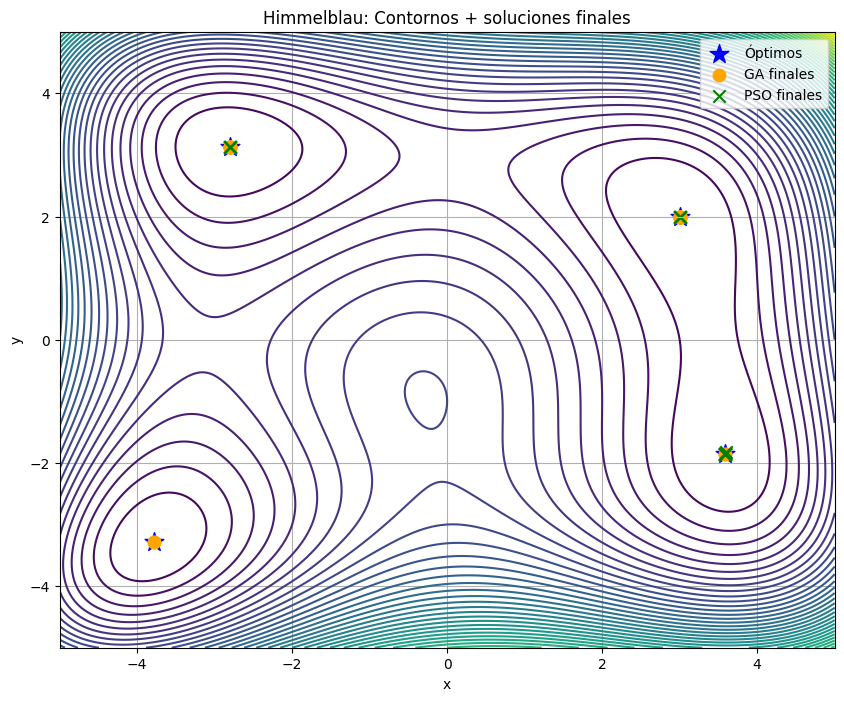

In [ ]:

# Contornos de Himmelblau

x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

# Óptimos conocidos
optima = np.array([
    [ 3.0,  2.0],
    [-2.805118,  3.131312],
    [-3.779310, -3.283186],
    [ 3.584428, -1.848126]
])

plt.figure(figsize=(10, 8))

plt.contour(X, Y, Z, levels=50, cmap="viridis")

plt.scatter(optima[:,0], optima[:,1],
            marker="*", s=200, c="blue", label="Óptimos")

plt.scatter(ga_solutions[:,0], ga_solutions[:,1],
            c="orange", s=80, label="GA finales")

plt.scatter(pso_solutions[:,0], pso_solutions[:,1],
            c="green", marker="x", s=80, label="PSO finales")

plt.title("Himmelblau: Contornos + soluciones finales")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


La figura muestra los contornos de la función de Himmelblau junto con las soluciones finales obtenidas
por el algoritmo genético (GA) y el PSO tras varias ejecuciones independientes. Las estrellas azules
indican la posición exacta de los cuatro óptimos globales.

Se observa que las soluciones finales del GA coinciden prácticamente con los óptimos globales,
mostrando una concentración muy alta alrededor de los mínimos. Esto indica que el GA alcanza de
forma consistente el fondo de las cuencas de atracción de la función.

Por el contrario, las soluciones del PSO se sitúan muy cerca de los óptimos, pero presentan una ligera
dispersión alrededor de los mínimos. Este comportamiento refleja el carácter más exploratorio del
PSO, que mantiene movimiento incluso en las últimas iteraciones.

La figura confirma visualmente los resultados cuantitativos: el GA explota de forma más eficaz las
regiones óptimas, mientras que el PSO obtiene soluciones próximas al óptimo con mayor variabilidad.
